In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('recruitment_data.csv')

In [3]:
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [4]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (1500, 11)

Columns in DataFrame:  ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy', 'HiringDecision']

Data types of columns:
 Age                      int64
Gender                   int64
EducationLevel           int64
ExperienceYears          int64
PreviousCompanies        int64
DistanceFromCompany    float64
InterviewScore           int64
SkillScore               int64
PersonalityScore         int64
RecruitmentStrategy      int64
HiringDecision           int64
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non

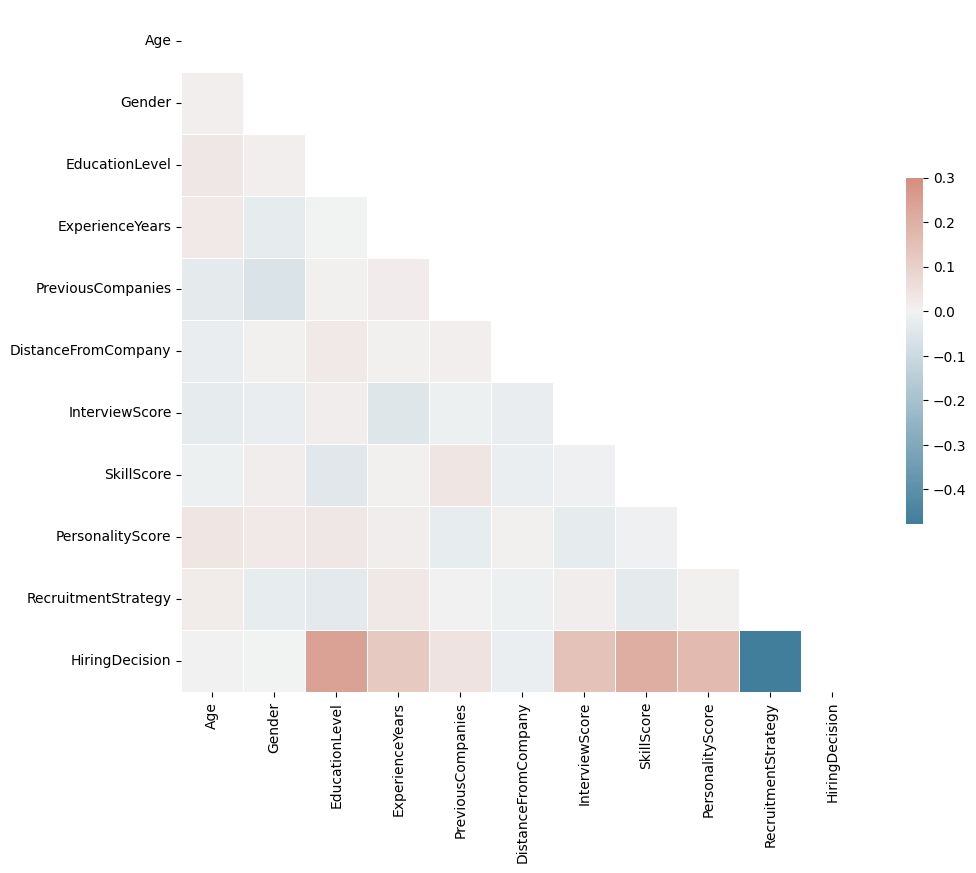

In [5]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [6]:
# Define the features and the target
X = df.drop('HiringDecision', axis=1)
y = df['HiringDecision']

In [7]:
def apply_models(X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check for class imbalance
    class_counts = np.bincount(y_train)
    if len(class_counts) > 2 or np.min(class_counts) / np.max(class_counts) < 0.1:
      print("Class imbalance detected. Applying SMOTE...")
    
    # Apply SMOTE (class imbalance)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both training and test data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the models
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVC': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'ExtraTrees': ExtraTreesClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoost': GradientBoostingClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0)
    }

    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the accuracy and f1 score
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, f1)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Sort the models based on f1 score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on F1 Score:\033[0m\n", top_3_models)

    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

In [8]:
apply_models(X, y)



Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.8366666666666667

**Confusion Matrix**:
 [[176  39]
 [ 10  75]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88       215
           1       0.66      0.88      0.75        85

    accuracy                           0.84       300
   macro avg       0.80      0.85      0.82       300
weighted avg       0.86      0.84      0.84       300


Classification with SVC:
------------------------------
**Accuracy**:
 0.8733333333333333

**Confusion Matrix**:
 [[190  25]
 [ 13  72]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       215
           1       0.74      0.85      0.79        85

    accuracy                           0.87       300
   macro avg       0.84      0.87      0.85       300
weighted avg       0.88      0.87      0.88       30

/home/user/workspace/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


**Accuracy**:
 0.9066666666666666

**Confusion Matrix**:
 [[195  20]
 [  8  77]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       215
           1       0.79      0.91      0.85        85

    accuracy                           0.91       300
   macro avg       0.88      0.91      0.89       300
weighted avg       0.91      0.91      0.91       300


Classification with XGBoost:
------------------------------
**Accuracy**:
 0.91

**Confusion Matrix**:
 [[198  17]
 [ 10  75]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       215
           1       0.82      0.88      0.85        85

    accuracy                           0.91       300
   macro avg       0.88      0.90      0.89       300
weighted avg       0.91      0.91      0.91       300


Classification with LightGBM:
------------------------------
[LightGBM] [Info]

/home/user/workspace/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/home/user/workspace/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.11/subprocess.py", line 1953, in _execute_child
    raise child_exception_type(errno_num, err_msg, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1640, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
**Accuracy**:
 0.9133333333333333

**Confusion Matrix**:
 [[200  15]
 [ 11  74]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       215
           1       0.83      0.87      0.85        85

    accuracy                           0.91       300
   macro avg       0.89      0.90      0.89       300
weighted avg       0.91      0.91      0.91       300


Classification with CatBoost:
------------------------------
**Accuracy**:
 0.9266666666666666

**Confusion Matrix**:
 [[201  14]
 [